<a href="https://colab.research.google.com/github/pathikritsyam/ECTA/blob/main/ANN/ANN_PSO_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display

def my_css(info=None, *args, **kwargs):
    display(HTML("""
    <style>
        table.dataframe td {
            white-space: nowrap;
        }
    </style>
    """))

get_ipython().events.register('pre_run_cell', my_css)


In [2]:
import tensorflow as tf
# Solo configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU disponible: {physical_devices[0]}")
else:
    print("No hay GPU disponible. Usando CPU.")

No hay GPU disponible. Usando CPU.


# 04.02 - Exploratory Data Analysis & ANN & Genetic Algorithm - Full Notebook

## Imports & setup

In [3]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [4]:
dtypes = {'Temperature': np.float64, 'Dewpoint Temp':np.float64, 'Relative Humidity':np.float64,
          'Wind Speed': np.float64, 'Visibility': np.float64, 'Pressure': np.float64,
          'Wind_Chill': np.float64,
         'Hour_of_Day': np.float64, 'Year': np.float64, 'Month': np.float64,
         'Day_Of_Week': np.float64, 'Day_of_Year': np.float64, 'Week_Of_Year': np.float64,
          'Quarter': np.float64, 'Stat_Hol': np.float64}


df_orig = pd.read_excel("../data/ECTA 2023 Dataset.xlsx")

# Convert Date column to datetime with dayfirst=True and handle errors
df_orig['Date'] = pd.to_datetime(df_orig['Date'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates (NaT)
df_orig = df_orig.dropna(subset=['Date'])

# Set Date as index
df_orig.set_index('Date', inplace=True)

# Apply dtypes to relevant columns
for col, dtype in dtypes.items():
    if col in df_orig.columns:
        df_orig[col] = df_orig[col].astype(dtype)

daymapper = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
weekdaymapper = {0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday',
                 5: 'Weekend', 6: 'Weekend'}
df_orig['dayofweek'] = df_orig['Day_Of_Week'].map(daymapper)
df_orig['daytype'] = df_orig['Day_Of_Week'].map(weekdaymapper)

print(f"Dataset loaded successfully. Shape: {df_orig.shape}")


Dataset loaded successfully. Shape: (96360, 18)


In [5]:
df_orig.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [6]:
df_orig.tail()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2020-12-31,19:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,19.0,94.0,9.0,16.1,99.21,-11.702041,0.8,1.6,Thu,Weekday
2020-12-31,20:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,20.0,95.0,9.0,11.3,99.21,-11.702041,0.4,1.1,Thu,Weekday
2020-12-31,21:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,21.0,97.0,7.0,9.7,99.20,-11.702041,0.6,1.0,Thu,Weekday
2020-12-31,22:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,22.0,97.0,7.0,9.7,99.20,-11.702041,0.5,0.9,Thu,Weekday
2020-12-31,23:00:00,2020.0,4.0,12.0,53.0,365.0,3.0,0.0,23.0,96.0,7.0,8.0,99.19,-11.702041,0.1,0.6,Thu,Weekday


In [7]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96360 entries, 2010-01-01 to 2020-12-31
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time               96360 non-null  object 
 1   Year               96360 non-null  float64
 2   Quarter            96360 non-null  float64
 3   Month              96360 non-null  float64
 4   Week_Of_Year       96360 non-null  float64
 5   Day_of_Year        96360 non-null  float64
 6   Day_Of_Week        96360 non-null  float64
 7   Stat_Hol           96360 non-null  float64
 8   Hour_of_Day        96360 non-null  float64
 9   Relative Humidity  96360 non-null  float64
 10  Wind Speed         96360 non-null  float64
 11  Visibility         96360 non-null  float64
 12  Pressure           96360 non-null  float64
 13  Wind_Chill         96360 non-null  float64
 14  Dewpoint Temp      96360 non-null  float64
 15  Temperature        96360 non-null  float64
 16  dayof

In [8]:
for col in df_orig.columns:
    print(col)

Time
Year
Quarter
Month
Week_Of_Year
Day_of_Year
Day_Of_Week
Stat_Hol
Hour_of_Day
Relative Humidity
Wind Speed
Visibility
Pressure
Wind_Chill
Dewpoint Temp
Temperature
dayofweek
daytype


In [9]:
df_orig['Year'].value_counts()

Year
2010.0    8760
2011.0    8760
2012.0    8760
2013.0    8760
2014.0    8760
2015.0    8760
2016.0    8760
2017.0    8760
2018.0    8760
2019.0    8760
2020.0    8760
Name: count, dtype: int64

### Data for Every Hour in 2008

In [10]:
pd.set_option('display.max_columns', 100)
df2018 = df_orig.loc['2010':'2015', :].copy(deep=True)
df2018.head()

,Time,Year,Quarter,Month,Week_Of_Year,Day_of_Year,Day_Of_Week,Stat_Hol,Hour_of_Day,Relative Humidity,Wind Speed,Visibility,Pressure,Wind_Chill,Dewpoint Temp,Temperature,dayofweek,daytype
Date,,,,,,,,,,,,,,,,,,
2010-01-01,00:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,0.0,76.0,26.0,25.0,99.26,-18.0,-12.7,-9.3,Fri,Weekday
2010-01-01,01:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,1.0,76.0,26.0,25.0,99.26,-18.0,-12.8,-9.3,Fri,Weekday
2010-01-01,02:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,2.0,74.0,26.0,25.0,99.29,-18.0,-13.4,-9.6,Fri,Weekday
2010-01-01,03:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,3.0,72.0,22.0,25.0,99.35,-18.0,-13.9,-9.8,Fri,Weekday
2010-01-01,04:00:00,2010.0,1.0,1.0,53.0,1.0,4.0,1.0,4.0,74.0,32.0,24.1,99.42,-19.0,-13.5,-9.7,Fri,Weekday


In [11]:
df2018.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,52560.0,2012.500000,1.707841,2010.00,2011.000000,2012.500000,2014.000000,2015.00
Quarter,52560.0,2.509589,1.116778,1.00,2.000000,3.000000,4.000000,4.00
Month,52560.0,6.526027,3.447884,1.00,4.000000,7.000000,10.000000,12.00
Week_Of_Year,52560.0,26.612785,15.063535,1.00,14.000000,27.000000,40.000000,53.00
Day_of_Year,52560.0,183.279452,105.446198,1.00,92.000000,183.000000,275.000000,366.00
Day_Of_Week,52560.0,3.000000,1.999106,0.00,1.000000,3.000000,5.000000,6.00
Stat_Hol,52560.0,0.027397,0.163240,0.00,0.000000,0.000000,0.000000,1.00
Hour_of_Day,52560.0,11.500000,6.922252,0.00,5.750000,11.500000,17.250000,23.00
Relative Humidity,52560.0,69.163271,16.035276,17.00,58.000000,70.000000,81.000000,100.00
Wind Speed,52560.0,16.145824,9.924293,0.00,9.000000,15.000000,22.000000,76.00


In [12]:
import sklearn 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [13]:
df2018.columns

Index(['Time', 'Year', 'Quarter', 'Month', 'Week_Of_Year', 'Day_of_Year',
       'Day_Of_Week', 'Stat_Hol', 'Hour_of_Day', 'Relative Humidity',
       'Wind Speed', 'Visibility', 'Pressure', 'Wind_Chill', 'Dewpoint Temp',
       'Temperature', 'dayofweek', 'daytype'],
      dtype='object')

In [14]:
features_train=df2018[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
features_train
scaler=StandardScaler()
Train=scaler.fit_transform(np.array(features_train))
Train

array([[-1.67744202, -1.56120128,  0.42635964, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-1.67744202, -1.57105377,  0.42635964, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-1.70501307, -1.63016868,  0.30163344, ..., -1.72866533,
         1.75174456, -1.35174944],
       ...,
       [ 0.03196304,  0.47826318,  1.42416922, ...,  1.73284851,
         1.75174456,  1.33457658],
       [ 0.05953409,  0.45855821,  1.23707992, ...,  1.73284851,
         1.75174456,  1.33457658],
       [-0.03236941,  0.14327868,  0.42635964, ...,  1.73284851,
         1.75174456,  1.33457658]], shape=(52560, 12))

In [15]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,Temperature,Dewpoint Temp,Relative Humidity,Wind Speed,Visibility,Pressure,Hour_of_Day,Month,Day_Of_Week,Day_of_Year,Week_Of_Year,Quarter
Temperature,1.00000,0.93431,-0.21288,-0.10215,0.01799,-0.16034,0.10574,0.27913,0.00027,0.27583,0.27105,0.28300
Dewpoint Temp,0.93431,1.00000,0.14335,-0.17904,-0.17072,-0.25192,0.01612,0.32763,-0.00173,0.32453,0.31979,0.32933
Relative Humidity,-0.21288,0.14335,1.00000,-0.21421,-0.57124,-0.26503,-0.25246,0.12393,-0.00415,0.12447,0.12469,0.12003
Wind Speed,-0.10215,-0.17904,-0.21421,1.00000,0.12523,-0.28567,0.13531,-0.06306,0.01699,-0.06484,-0.06787,-0.06118
Visibility,0.01799,-0.17072,-0.57124,0.12523,1.00000,0.27541,0.05450,0.01978,-0.00943,0.02087,0.01977,0.01680
Pressure,-0.16034,-0.25192,-0.26503,-0.28567,0.27541,1.00000,-0.00851,0.00887,0.00521,0.01034,0.01428,0.00476
Hour_of_Day,0.10574,0.01612,-0.25246,0.13531,0.05450,-0.00851,1.00000,0.00000,-0.00000,0.00000,0.00000,0.00000
Month,0.27913,0.32763,0.12393,-0.06306,0.01978,0.00887,0.00000,1.00000,-0.00033,0.99650,0.96873,0.97136
Day_Of_Week,0.00027,-0.00173,-0.00415,0.01699,-0.00943,0.00521,-0.00000,-0.00033,1.00000,-0.00012,0.00067,-0.00061
Day_of_Year,0.27583,0.32453,0.12447,-0.06484,0.02087,0.01034,0.00000,0.99650,-0.00012,1.00000,0.97006,0.96820


In [16]:
pd.set_option('display.max_columns', 100)

dftest = df_orig.loc['2016', :].copy(deep=True)
# dftest.head()
features_test= dftest[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
Test=scaler.transform(np.array(features_test))
Test

array([[-0.29888955, -0.23111576,  0.11454414, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-0.4367448 , -0.44787044, -0.13490826, ..., -1.72866533,
         1.75174456, -1.35174944],
       [-0.59298074, -0.61536269, -0.13490826, ..., -1.72866533,
         1.75174456, -1.35174944],
       ...,
       [-1.30982803, -1.0094621 ,  1.11235373, ...,  1.72336491,
         1.68535845,  1.33457658],
       [-1.29144733, -1.03901956,  0.92526443, ...,  1.72336491,
         1.68535845,  1.33457658],
       [-1.31901838, -1.02916707,  1.04999063, ...,  1.72336491,
         1.68535845,  1.33457658]], shape=(8760, 12))

In [17]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [18]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-1.67744202 -1.56120128  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.66132477 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.67744202 -1.57105377  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.51686175 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.70501307 -1.63016868  0.30163344  0.99294424  0.7356133  -0.35454046
 -1.37239873 -1.60274527  0.50022847 -1.72866533  1.75174456]
[-1.67744202 -1.56120128  0.42635964  0.99294424  0.7356133  -0.39433948
 -1.66132477 -1.60274527  0.50022847 -1.72866533  1.75174456 -1.67744202
 -1.57105377  0.42635964  0.99294424  0.7356133  -0.39433948 -1.51686175
 -1.60274527  0.50022847 -1.72866533  1.75174456 -1.70501307 -1.63016868
  0.30163344  0.99294424  0.7356133  -0.35454046 -1.37239873 -1.60274527
  0.50022847 -1.72866533  1.75174456]


In [19]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-1.35174944, -1.35174944, -1.35174944, -1.35174944, -1.35174944,
       -1.35174944, -1.35174944, -1.35174944, -1.35174944, -1.35174944,
       -1.35174944, -1.35174944])

In [20]:
# print(Train.shape)
# print(Train[2:].shape)
#x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
#x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
#print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
#y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
#y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
#print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

## Particle Swarm Optimisation

In [21]:
idx_temp = 0

In [22]:
window_size = 3   # pasos pasados
forecast_horizon = 24  # pasos futuros

X_train, y_train = [], []

for i in range(len(Train) - window_size - forecast_horizon):
    # Concatenamos 3 pasos (cada uno con las 12 features)
    X_train.append(Train[i : i + window_size].flatten())
    
    # Tomamos los siguientes 24 valores de Temperature
    y_train.append(np.stack([Train[i + window_size + j, idx_temp] 
                             for j in range(forecast_horizon)]))

x_train = np.array(X_train)
y_train = np.array(y_train)

In [23]:
X_test, y_test = [], []

for i in range(len(Test) - window_size - forecast_horizon):
    X_test.append(Test[i : i + window_size].flatten())
    y_test.append(np.stack([Test[i + window_size + j, idx_temp] 
                            for j in range(forecast_horizon)]))

X_test = np.array(X_test)
y_test = np.array(y_test)


In [24]:
# Tras armar X_train, y_train, X_test, y_test (listas)
import numpy as np

x_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)  # o Y_train si así lo llamaste

x_test  = np.asarray(X_test,  dtype=np.float32)
y_test  = np.asarray(y_test,  dtype=np.float32)



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
test_size=0.25)

In [27]:
def ANN_model(lr, batch_sz, ep):
  model = Sequential()
  # Defining the input layer
  # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


  # Defining the  two hidden layers
  # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # if op == "sgd":
  #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

  # elif op == "adamax":
  #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

  # elif op == "adam":
  #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # elif op == "adagrad":
  #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

  # else:
  #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # Compiling the model
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer='Adam')

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=1)

  return model

In [28]:
from keras.losses import mean_squared_error as MSE
from keras.losses import MeanAbsoluteError
import random

In [ ]:
import numpy as np
import tensorflow as tf

# Listas discretas "amables"
BATCH_OPTIONS = [16, 32, 48, 64, 96, 128, 160, 192, 224, 256]
EPOCH_MIN, EPOCH_MAX = 20, 120  # mantén amplio pero razonable

def snap_discrete(epoch, batch):
    epoch = int(np.clip(round(epoch), EPOCH_MIN, EPOCH_MAX))
    batch = int(min(BATCH_OPTIONS, key=lambda b: abs(b - batch)))
    return epoch, batch

# Cache para evitar recomputar el mismo punto
_fitness_cache = {}

def fitness_function(lr, epoch, batch_size):
    # Acotar y discretizar 
    lr = float(np.clip(lr, 1e-5, 1.0))
    epoch, batch_size = snap_discrete(epoch, batch_size)

    key = (round(lr, 6), epoch, batch_size)
    if key in _fitness_cache:
        return _fitness_cache[key]

    # Entrena ANN 
    model = ANN_model(lr, batch_size, epoch)  # <- usa ANN actual
    # FITNESS EN VALIDACIÓN
    y_pred_val = model.predict(x_val, verbose=0)
    mse = tf.keras.losses.MeanSquaredError()(y_val, y_pred_val).numpy()

    _fitness_cache[key] = float(mse)
    return float(mse)


In [30]:
import random

class Particle:
    def __init__(self, lr_range, ep_range, bs_range):
        self.lr_range = lr_range
        self.ep_range = ep_range
        self.bs_range = bs_range

        # posición continua; epochs/batch se "snappean" en fitness
        self.position = np.array([
            random.uniform(*lr_range),
            random.uniform(*ep_range),
            random.uniform(*bs_range)
        ], dtype=float)

        self.velocity = np.zeros(3, dtype=float)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

    def clip_position(self):
        self.position[0] = np.clip(self.position[0], *self.lr_range)
        self.position[1] = np.clip(self.position[1], *self.ep_range)
        self.position[2] = np.clip(self.position[2], *self.bs_range)

    def clip_velocity(self, vmax):
        self.velocity = np.clip(self.velocity, -vmax, vmax)


In [ ]:

class PSO:
    """
    - Constriction factor (Clerc): más estable.
    - Inercia adaptativa: explora al inicio, explota al final.
    - Topología en anillo: mantiene diversidad (evita colapso al gbest).
    - Clamp de velocidad: evita saltos enormes entre iteraciones.
    - Early stop del PSO: corta si deja de mejorar.
    """
    def __init__(self,
                 lr_range=(1e-4, 3e-2),
                 ep_range=(EPOCH_MIN, EPOCH_MAX),
                 bs_range=(min(BATCH_OPTIONS), max(BATCH_OPTIONS)),
                 n_particles=12, n_iters=15, ring_k=2,
                 c1=2.05, c2=2.05, w_max=0.9, w_min=0.4, patience=4):
        self.lr_range, self.ep_range, self.bs_range = lr_range, ep_range, bs_range
        self.n_particles = n_particles
        self.n_iters = n_iters
        self.ring_k = ring_k
        self.c1, self.c2 = c1, c2
        self.w_max, self.w_min = w_max, w_min
        self.patience = patience

        # Clerc constriction
        phi = c1 + c2
        self.chi = 2.0 / (phi - 2.0 + np.sqrt(phi**2 - 4.0*phi))

        # Velocidad máxima por dimensión 
        self.vmax = np.array([
            0.1*(lr_range[1]-lr_range[0]),
            0.1*(ep_range[1]-ep_range[0]),
            0.1*(bs_range[1]-bs_range[0]),
        ], dtype=float)

        self.particles = [Particle(lr_range, ep_range, bs_range) for _ in range(n_particles)]
        self.global_best_position = self.particles[0].position.copy()
        self.global_best_fitness = float('inf')

    def _neighborhood_best(self, idx):
        idxs = [(idx + d) % self.n_particles for d in range(-self.ring_k, self.ring_k+1)]
        best_pos, best_fit = None, float('inf')
        for j in idxs:
            pf = self.particles[j].best_fitness
            if pf < best_fit:
                best_fit = pf
                best_pos = self.particles[j].best_position
                
    # Fallback: si nadie tiene best todavía, usa el propio best/pos actual
        if best_pos is None:
            best_pos = self.particles[idx].best_position
            best_fit = self.particles[idx].best_fitness
        return best_pos, best_fit


    def optimize(self, seed=None):
        if seed is not None:
            import random
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)

        # --- BOOTSTRAP: evaluar una vez todas las partículas ---
        self.global_best_fitness = float('inf')
        for p in self.particles:
            p.clip_position()
            fit = fitness_function(*p.position)
            p.best_fitness = fit
            p.best_position = p.position.copy()
            if fit < self.global_best_fitness:
                self.global_best_fitness = fit
                self.global_best_position = p.position.copy()

        no_improve = 0
        for it in range(self.n_iters):
            w = self.w_max - (self.w_max - self.w_min) * (it / max(1, self.n_iters-1))
            for i, p in enumerate(self.particles):
                nbest_pos, _ = self._neighborhood_best(i)

                r1, r2 = np.random.rand(3), np.random.rand(3)
                cognitive = self.c1 * r1 * (p.best_position - p.position)
                social    = self.c2 * r2 * (nbest_pos       - p.position)

                p.velocity = self.chi * (w*p.velocity + cognitive + social)
                p.clip_velocity(self.vmax)
                p.position += p.velocity
                p.clip_position()

                fit = fitness_function(*p.position)

                if fit < p.best_fitness:
                    p.best_fitness = fit
                    p.best_position = p.position.copy()

                if fit < self.global_best_fitness:
                    self.global_best_fitness = fit
                    self.global_best_position = p.position.copy()
                    no_improve = 0
                else:
                    no_improve += 1

            print(f"Iter {it+1}/{self.n_iters} | w={w:.2f} | best_fitness={self.global_best_fitness:.6f} | best_pos={self.global_best_position}")

            if no_improve >= self.patience * self.n_particles:
                print("PSO early-stopped: sin mejoras recientes.")
                break

        lr, ep, bs = self.global_best_position
        ep, bs = snap_discrete(ep, bs)
        self.global_best_position = np.array([float(lr), int(ep), int(bs)], dtype=float)
        return self.global_best_position, float(self.global_best_fitness)


In [32]:
pso = PSO(
    lr_range=(1e-4, 3e-2),
    ep_range=(EPOCH_MIN, EPOCH_MAX),
    bs_range=(min(BATCH_OPTIONS), max(BATCH_OPTIONS)),
    n_particles=12, n_iters=15, ring_k=2,
)

(best_lr,  best_epoch, best_batch_size), best_fit = pso.optimize(seed=42)
print("Hiperparámetros óptimos (PSO):", best_lr,  best_epoch, best_batch_size)
print("Fitness (MSE val):", best_fit)


c:\Users\santo\OneDrive\Documentos\bio\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1867 - val_loss: 0.1081
Epoch 2/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0928 - val_loss: 0.0855
Epoch 3/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0833 - val_loss: 0.0803
Epoch 4/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0793 - val_loss: 0.0772
Epoch 5/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0766 - val_loss: 0.0751
Epoch 6/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0749 - val_loss: 0.0738
Epoch 7/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0736 - val_loss: 0.0728
Epoch 8/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0725 - val_loss: 0.0720
Epoch 9/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0717 - val_loss: 0.0713
Epoch 10/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0710 - val_loss: 0.0707
Epoch 11/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0704 - val_loss: 0.0702
Epoch 12/58
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [52]:
model=ANN_model(best_lr, int(best_batch_size), int(best_epoch))

c:\Users\santo\OneDrive\Documentos\bio\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1827 - val_loss: 0.1086
Epoch 2/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0948 - val_loss: 0.0861
Epoch 3/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0833 - val_loss: 0.0802
Epoch 4/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0792 - val_loss: 0.0771
Epoch 5/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0769 - val_loss: 0.0752
Epoch 6/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0752 - val_loss: 0.0741
Epoch 7/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0739 - val_loss: 0.0732
Epoch 8/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0729 - val_loss: 0.0723
Epoch 9/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0719 - val_loss: 0.0716
Epoch 10/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0711 - val_loss: 0.0709
Epoch 11/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0705 - val_loss: 0.0701
Epoch 12/66
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [53]:
from sklearn.metrics import mean_absolute_percentage_error

In [54]:
MAPE = mean_absolute_percentage_error(y_test, model.predict(X_test))
print("MAPE: ",MAPE)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE:  0.6751343607902527


In [55]:
y_test[:, 1].shape

(8733,)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


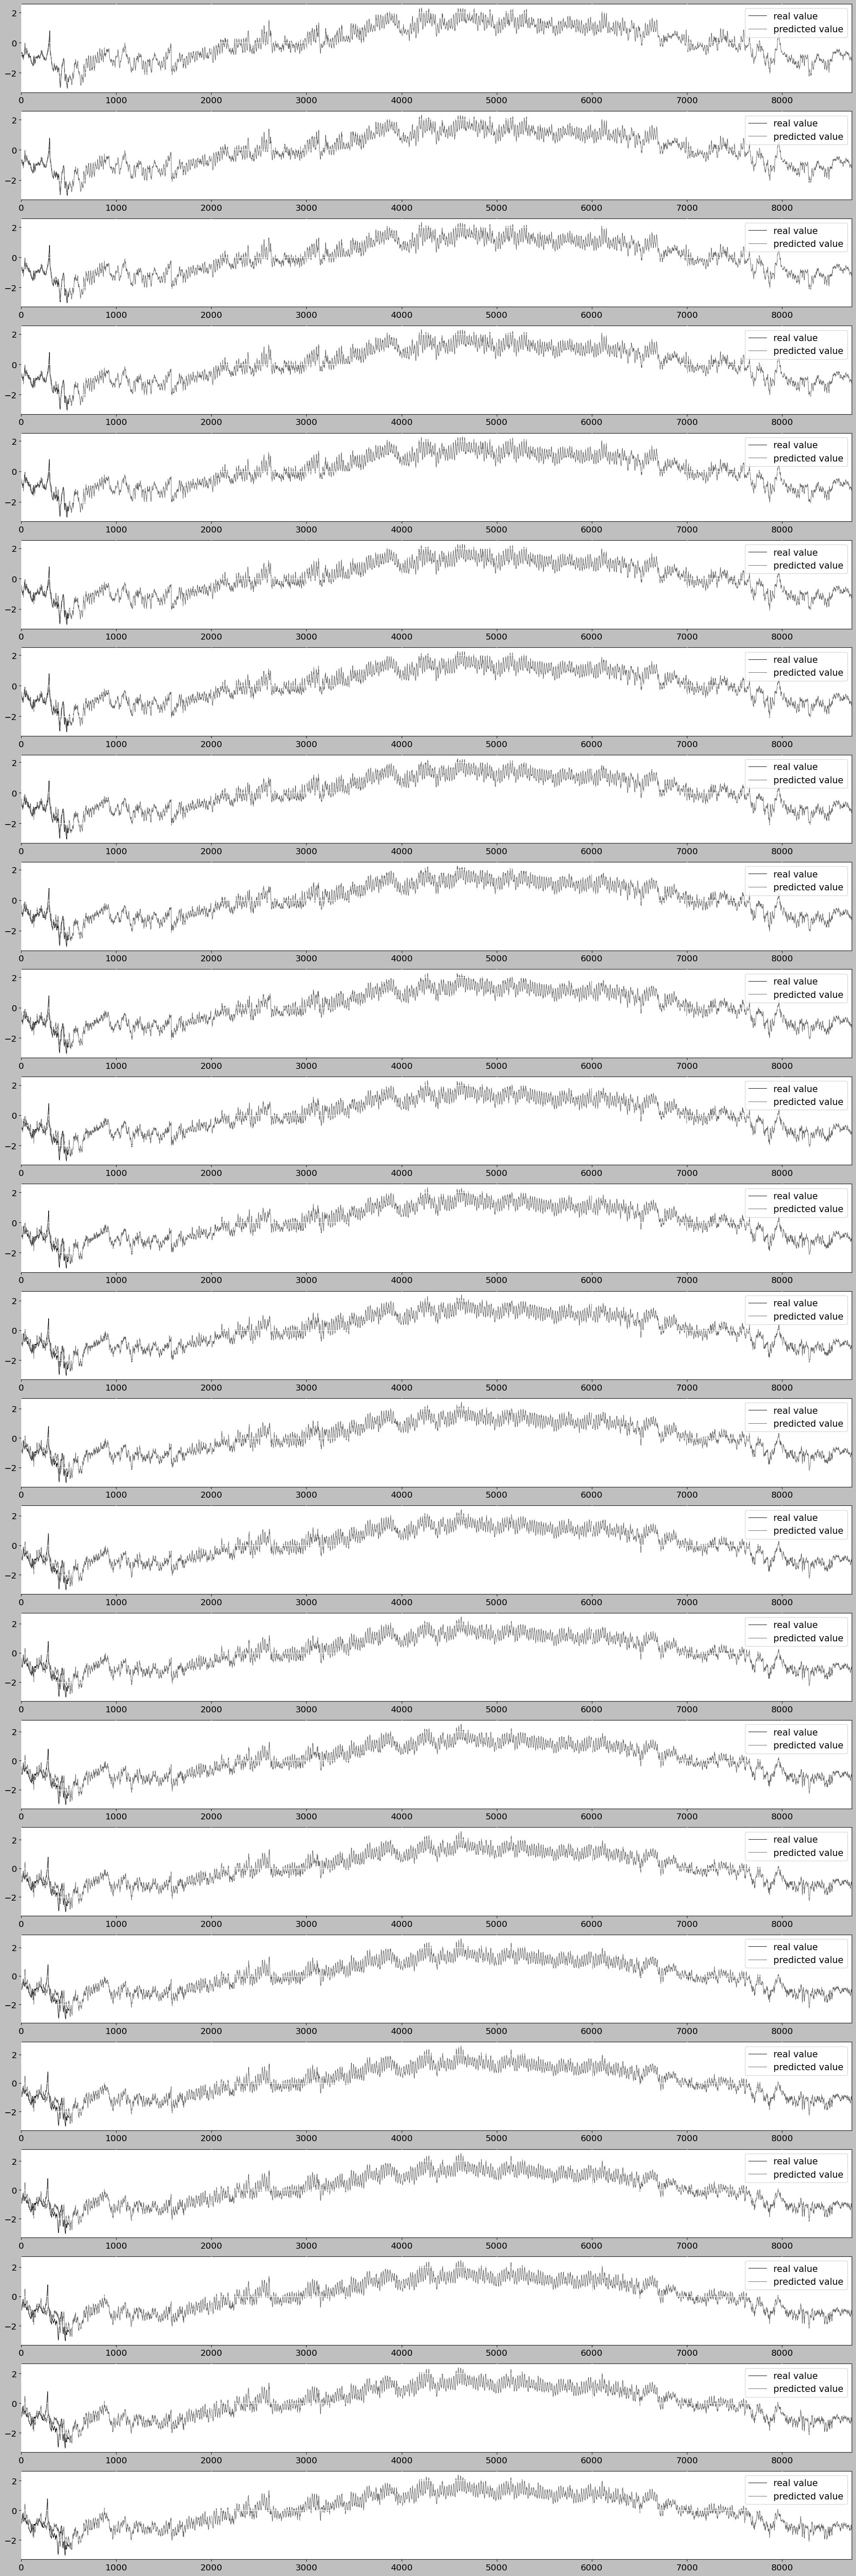

In [56]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(X_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

## PREDICTION FOR WHOLE YEAR

In [57]:
pd.set_option('display.max_columns', 100)
dfpredict_data = df_orig.loc['2017', :].copy(deep=True)
predict_data = dfpredict_data[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
predict_data

,Temperature,Dewpoint Temp,Relative Humidity,Wind Speed,Visibility,Pressure,Hour_of_Day,Month,Day_Of_Week,Day_of_Year,Week_Of_Year,Quarter
Date,,,,,,,,,,,,
2017-01-01,-5.2,-7.4,84.0,7.0,19.3,98.90,0.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.0,-7.0,86.0,0.0,19.3,98.96,1.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.4,-6.3,93.0,4.0,4.0,99.01,2.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-5.0,-5.6,96.0,4.0,2.0,99.05,3.0,1.0,6.0,1.0,52.0,1.0
2017-01-01,-4.6,-5.2,96.0,0.0,2.0,99.08,4.0,1.0,6.0,1.0,52.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,2.8,1.3,90.0,28.0,6.4,99.39,19.0,12.0,6.0,365.0,52.0,4.0
2017-12-31,2.7,2.2,97.0,24.0,6.4,99.17,20.0,12.0,6.0,365.0,52.0,4.0
2017-12-31,3.3,2.9,97.0,19.0,4.8,98.96,21.0,12.0,6.0,365.0,52.0,4.0


In [58]:
scaler=StandardScaler()
predict=scaler.fit_transform(np.array(predict_data))
predict

array([[-1.52485894, -1.26425484,  0.74393145, ..., -1.72731195,
         1.69005709, -1.35174944],
       [-1.50459762, -1.22180941,  0.86416501, ..., -1.72731195,
         1.69005709, -1.35174944],
       [-1.54512027, -1.14752991,  1.28498248, ..., -1.72731195,
         1.69005709, -1.35174944],
       ...,
       [-0.66375266, -0.171285  ,  1.52544961, ...,  1.72731195,
         1.69005709,  1.33457658],
       [-0.64349133, -0.15006228,  1.52544961, ...,  1.72731195,
         1.69005709,  1.33457658],
       [-0.63336067, -0.12883957,  1.58556639, ...,  1.72731195,
         1.69005709,  1.33457658]], shape=(8760, 12))

In [59]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (8734, 36)
yp.shape: (8734, 24)


In [60]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [61]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 1.3109013506869298
(8734, 24)
(8734, 24)
Worst MAPE: 5.16252739510496
Best MAPE: 0.03453208644132005


##VISUALISATION

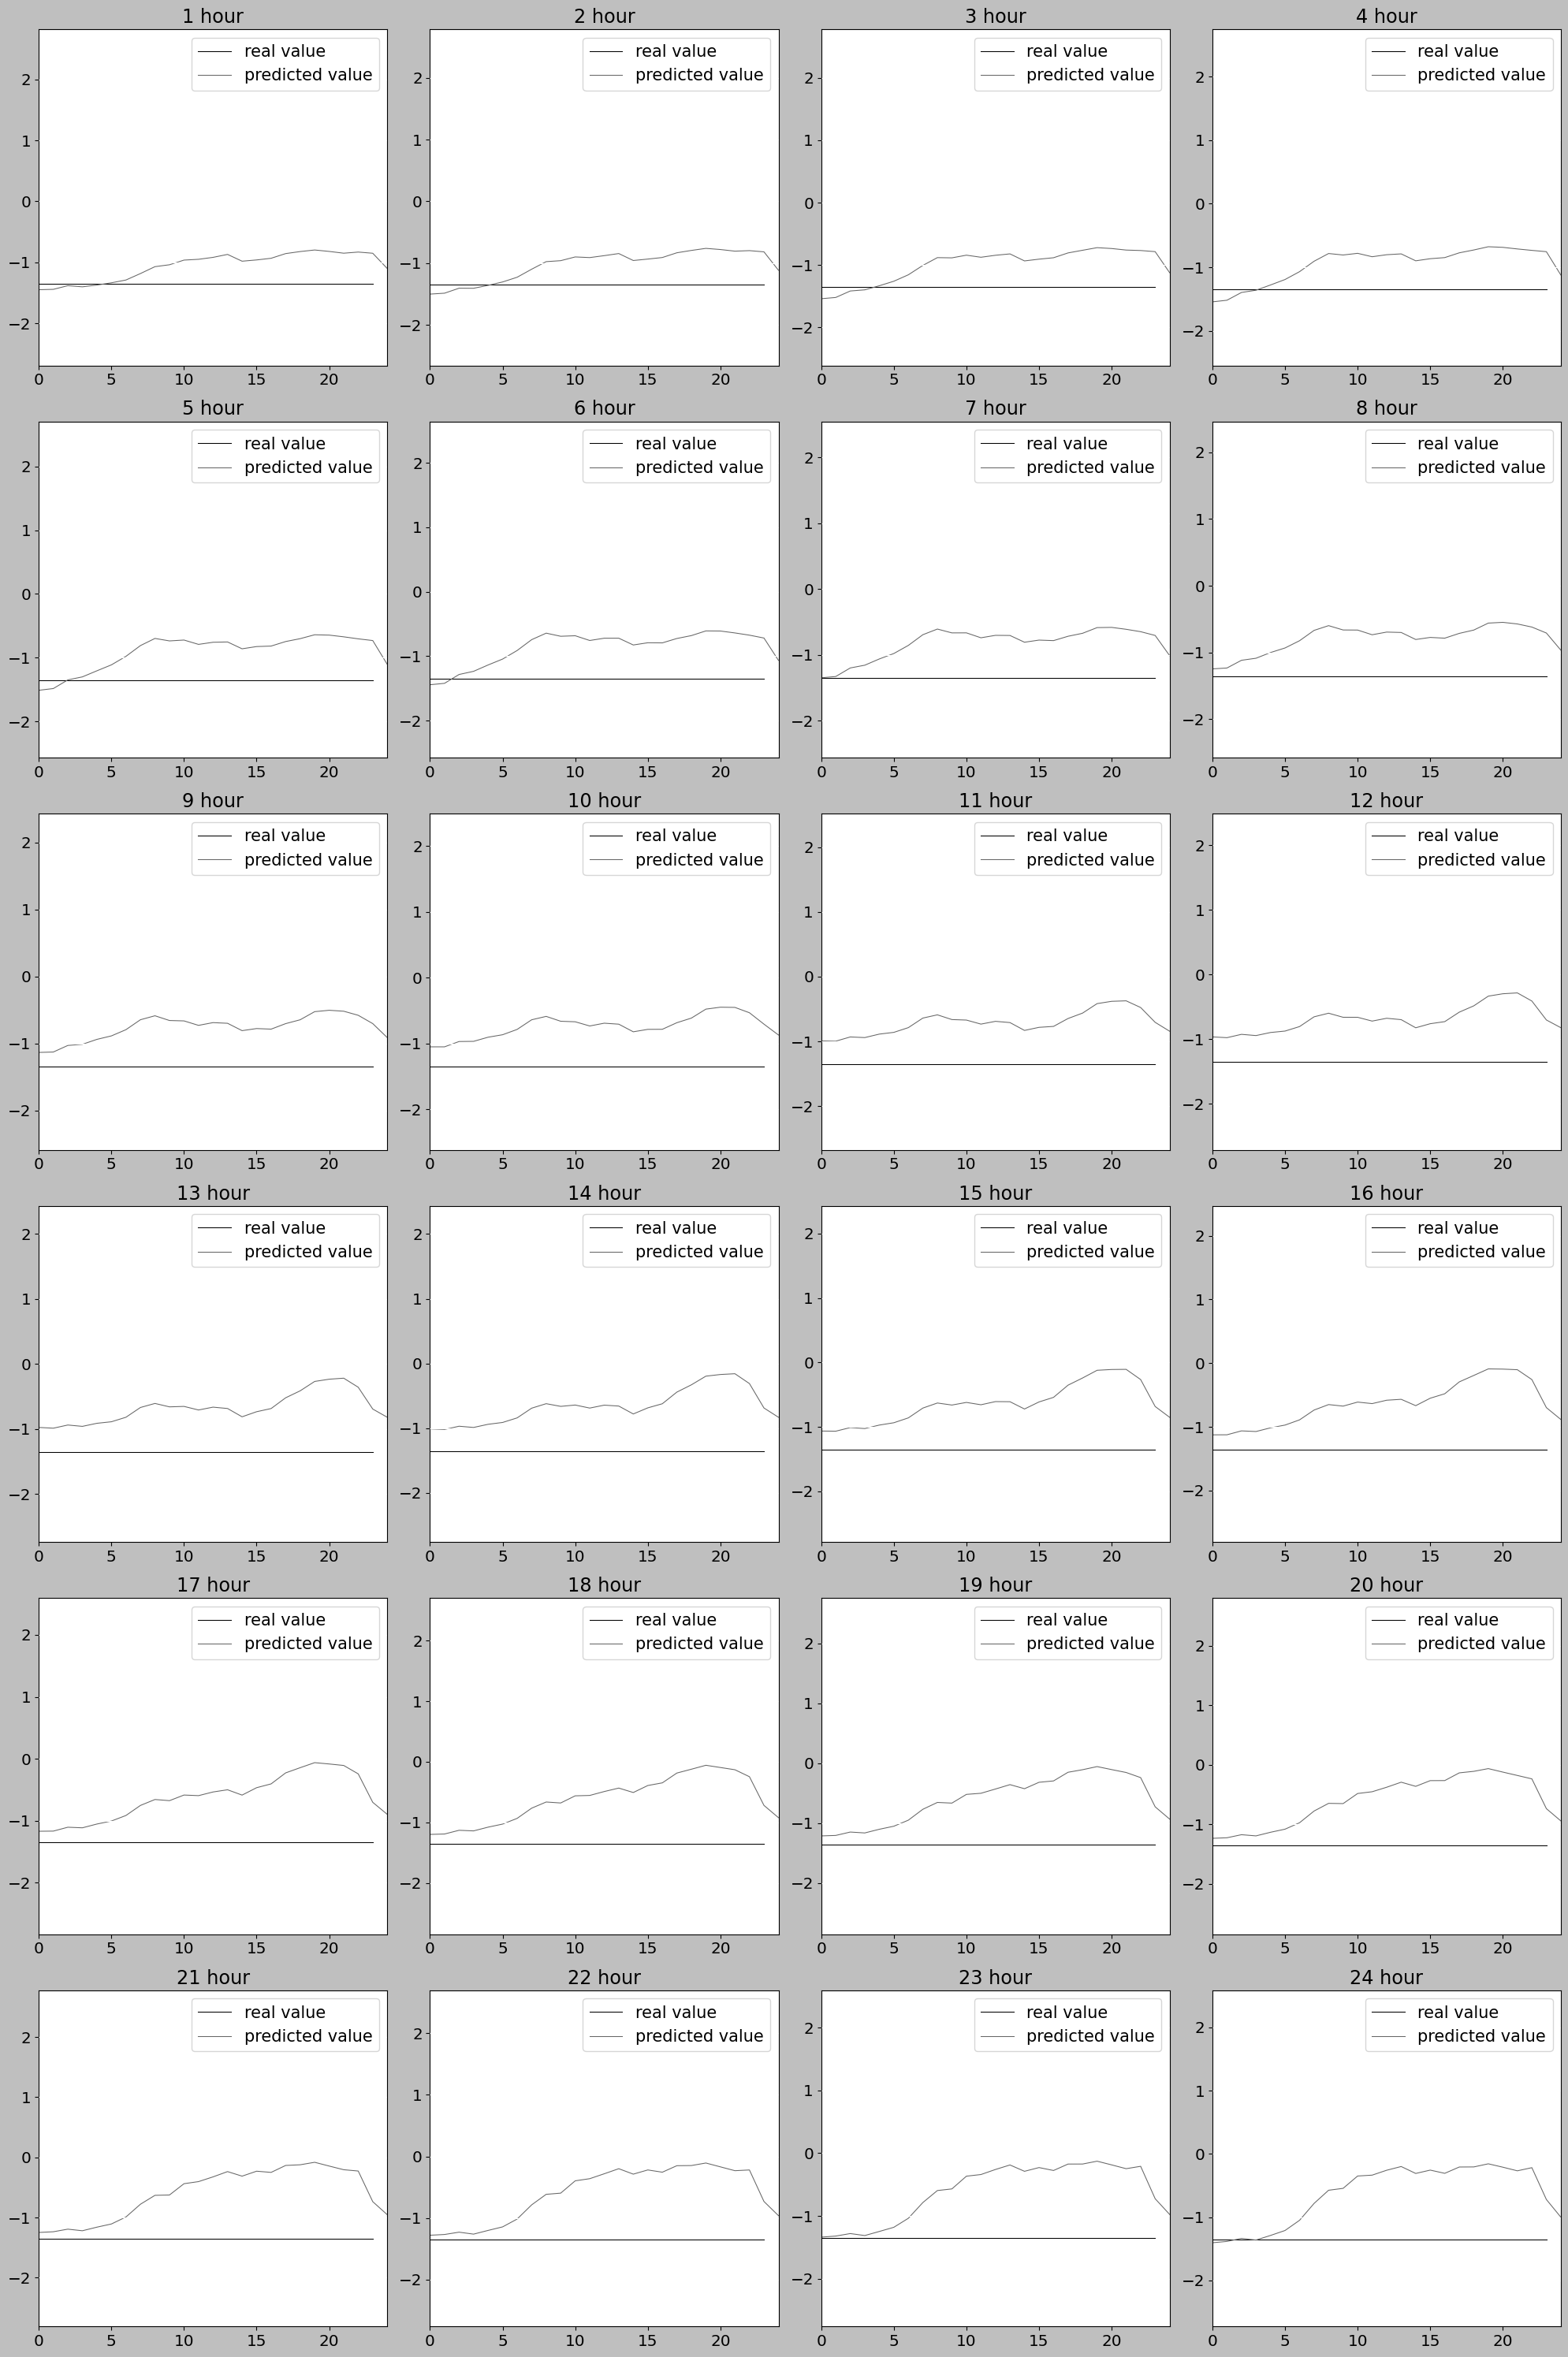

In [62]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [63]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])
def aggregate_plot(y_actual, y_pred):
  y_mean_pred = []
  for j in range(23, -1, -1):
    sum=0
    for i in range(0, 24):
      if j-i>=0:
        sum += y_pred[i][j-i]
    y_mean_pred.append(sum/(j+1))
  y_mean_pred = list(reversed(y_mean_pred))
  df_predict_aggregate['prediction_agg'] = y_mean_pred
  df_predict_aggregate['actual'] = y_actual

  mape = mean_absolute_percentage_error(yp, y_prediction)
  print(mape)
  plt.plot(y_actual, marker='*', color='blue')
  plt.plot(y_mean_pred, marker='+', color ='red')
  plt.legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
  plt.show()

In [64]:
df_predict_aggregate

,prediction_agg,actual


1.3109013506869298


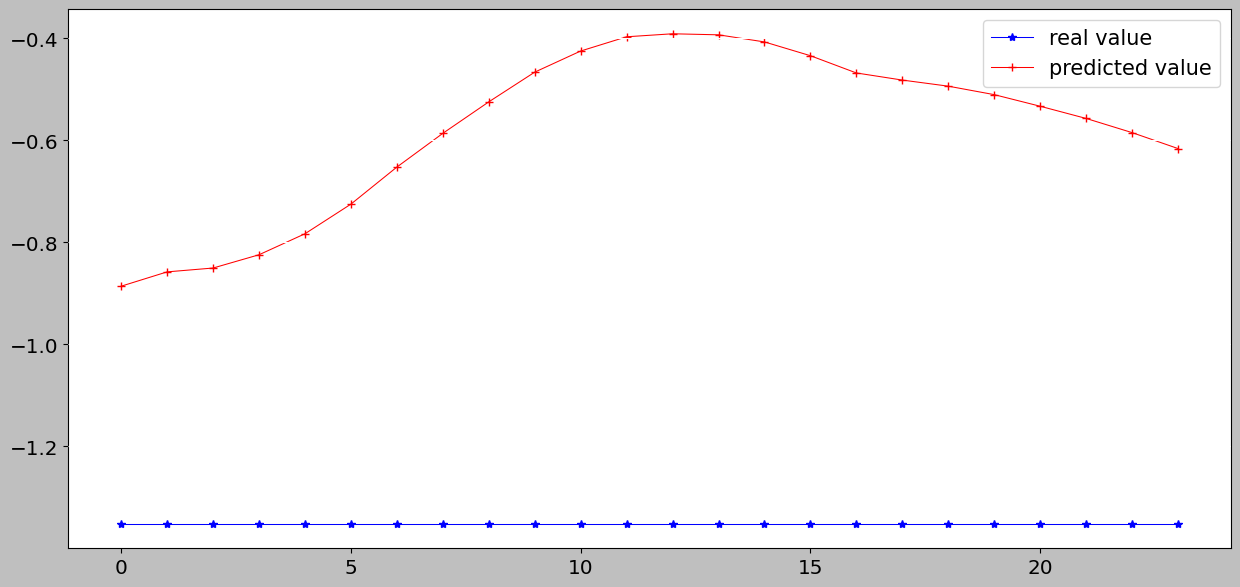

In [65]:
aggregate_plot(yp[240], y_prediction[240:264])

## METRICS OF PERFORMANCE

In [66]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 1.3109013506869298
(8734, 24)
(8734, 24)
Worst MAPE: 5.16252739510496
Best MAPE: 0.03453208644132005


In [67]:
# Índice de Temperature dentro de las 12 features usadas para escalar
idx_temp = 0  # si Temperature fue la primera columna (como en tu notebook)

temp_mean  = scaler.mean_[idx_temp]
temp_scale = scaler.scale_[idx_temp]

# y_predict e y_test están en escala estandarizada (z-score del feature Temperature)
# Desescalamos elemento a elemento (N, 24)
y_pred_real = y_predict * temp_scale + temp_mean
y_test_real = y_test    * temp_scale + temp_mean


In [68]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Globales (aplanando los 24 horizontes)
rmse_global = np.sqrt(mean_squared_error(y_test_real.ravel(), y_pred_real.ravel()))
mae_global  = mean_absolute_error(y_test_real.ravel(), y_pred_real.ravel())

# Por horizonte (columna 0 = t+1, …, columna 23 = t+24)
rmse_h = np.sqrt(np.mean((y_test_real - y_pred_real)**2, axis=0))
mae_h  = np.mean(np.abs(y_test_real - y_pred_real), axis=0)

print(f"RMSE global (°C): {rmse_global:.3f}")
print(f"MAE  global (°C): {mae_global:.3f}")
print("MAE por horizonte (°C):", np.round(mae_h, 3))
print("RMSE por horizonte (°C):", np.round(rmse_h, 3))


RMSE global (°C): 2.529
MAE  global (°C): 1.855
MAE por horizonte (°C): [0.712 0.892 1.064 1.213 1.346 1.469 1.576 1.674 1.763 1.835 1.898 1.963
 2.021 2.068 2.114 2.159 2.208 2.258 2.298 2.335 2.366 2.394 2.429 2.477]
RMSE por horizonte (°C): [0.938 1.182 1.406 1.596 1.765 1.922 2.06  2.187 2.304 2.402 2.493 2.584
 2.664 2.733 2.793 2.855 2.919 2.98  3.03  3.074 3.113 3.152 3.196 3.247]


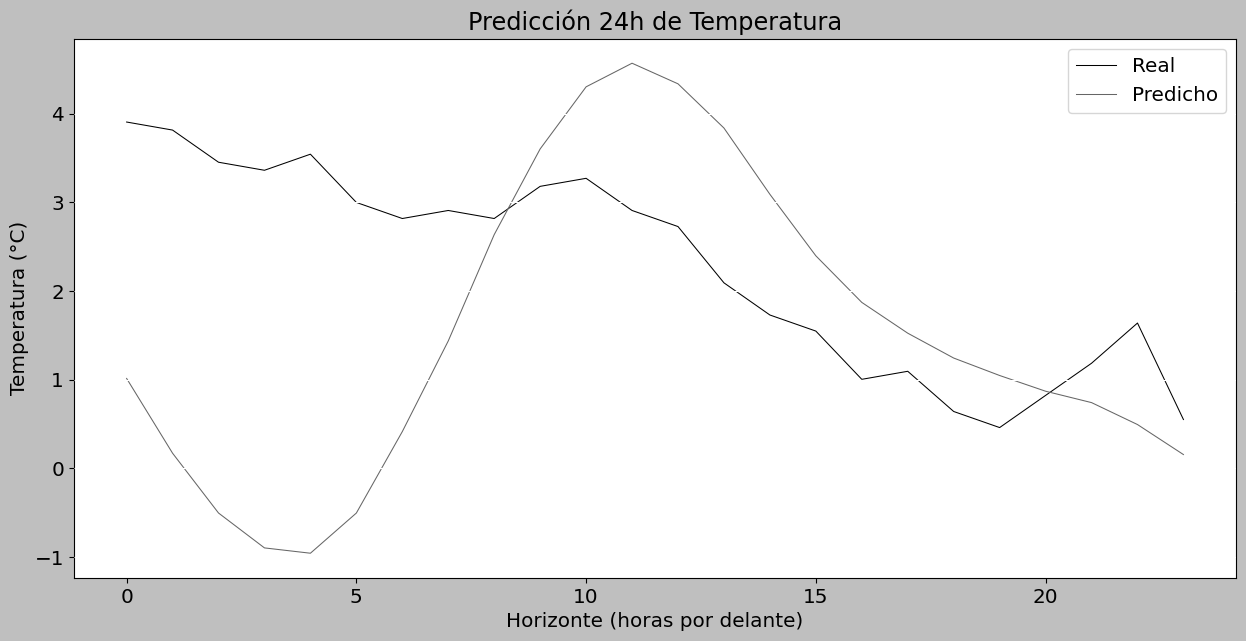

In [69]:
import matplotlib.pyplot as plt

k = 0  # elige una muestra del set (índice de fila)
plt.plot(y_test_real[k], label="Real")
plt.plot(y_pred_real[k], label="Predicho")
plt.xlabel("Horizonte (horas por delante)")
plt.ylabel("Temperatura (°C)")
plt.title("Predicción 24h de Temperatura")
plt.legend(); plt.show()

In [70]:
from sklearn.metrics import r2_score

# R² global (todas las horas y muestras)
r2_global = r2_score(y_test_real.ravel(), y_pred_real.ravel())
print(f"R² global: {r2_global:.3f}")

# R² por horizonte (columna 0 = t+1, …, columna 23 = t+24)
r2_h = [r2_score(y_test_real[:, i], y_pred_real[:, i]) for i in range(y_test_real.shape[1])]
print("R² por horizonte:", np.round(r2_h, 3))


R² global: 0.945
R² por horizonte: [0.992 0.988 0.983 0.978 0.973 0.968 0.964 0.959 0.955 0.951 0.947 0.943
 0.939 0.936 0.933 0.93  0.927 0.924 0.922 0.919 0.917 0.915 0.913 0.91 ]
